In [1]:
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Lambda,Dropout
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
# FETCH DATA
data_path = "./../recording.csv"
image_path = "./../_out/"


In [3]:
lines = []
with open(data_path) as csvfile:
        reader = csv.reader(csvfile)
        next(reader) # Skip header
        for line in reader:
            lines.append(line)

In [4]:
print(lines[:10])
print(len(lines))
print(len(lines[0][3]))

[['0.0', 'False', 'False', '28211', 'False', 'False', '0.0', 'RoadOption.LANEFOLLOW', '1', 'Green', '30.0', '', '1.0', '18.84993423666948'], ['0.0', 'False', 'True', '28215', 'False', 'False', '0.0', 'RoadOption.LANEFOLLOW', '1', 'Red', '30.0', 'Actor(id=26, type=traffic.traffic_light)', '1.0', '12.715931739238147'], ['0.0', 'False', 'True', '28219', 'False', 'False', '0.0', 'RoadOption.LANEFOLLOW', '1', 'Red', '30.0', 'Actor(id=26, type=traffic.traffic_light)', '1.0', '5.450461526530841'], ['0.0', 'False', 'True', '28224', 'False', 'False', '0.0', 'RoadOption.LANEFOLLOW', '1', 'Red', '30.0', 'Actor(id=26, type=traffic.traffic_light)', '1.0', '0.01751125442901313'], ['0.0', 'False', 'True', '28229', 'False', 'False', '0.0', 'RoadOption.LANEFOLLOW', '1', 'Red', '30.0', 'Actor(id=26, type=traffic.traffic_light)', '1.0', '0.006615490308559106'], ['0.0', 'False', 'True', '28233', 'False', 'False', '0.0', 'RoadOption.LANEFOLLOW', '1', 'Red', '30.0', 'Actor(id=26, type=traffic.traffic_light)

In [5]:

images = []
for line in lines:
    # Add padding to path
    l = len(line[3])
    pad = ''
    for i in range(8 - l):
        pad += '0'
    
    # Fetch images
    file_path = image_path + pad + line[3]+'.png'
    img = cv2.imread(file_path)
    img = img[..., ::-1]
    #img = cv2.resize(oriimg,(160,90))
    images.append(img)

    

In [6]:
print(len(lines))
print(len(images))
print(images[0])

21
21
[[[138 152 175]
  [137 152 175]
  [138 152 175]
  ...
  [137 152 175]
  [138 152 175]
  [137 152 175]]

 [[138 152 176]
  [137 152 175]
  [137 152 175]
  ...
  [137 152 175]
  [137 152 175]
  [137 152 175]]

 [[137 152 175]
  [137 152 175]
  [137 152 175]
  ...
  [137 152 175]
  [138 153 176]
  [138 152 175]]

 ...

 [[141 143 148]
  [140 142 147]
  [139 141 146]
  ...
  [117 118 124]
  [115 117 121]
  [113 115 120]]

 [[141 143 148]
  [140 142 147]
  [141 142 147]
  ...
  [114 115 121]
  [114 115 121]
  [114 117 121]]

 [[141 143 148]
  [140 141 146]
  [138 140 145]
  ...
  [115 117 122]
  [117 118 122]
  [115 118 122]]]


In [7]:
### NB Not needed when using tf.images.rgb2hsv
hsv=True
def normalize(x):
    if hsv:
        return x
    return np.divide(x, 255)-0.5


In [8]:
X_train, y_train, labels_train = [],[],[]
X_valid, y_valid, labels_valid = [],[],[]

split = int(len(lines) - len(lines)/4)
print(" Training on " + str(split) + " and validating on " + str(len(lines)-split))
for img, line in zip(images[:split], lines[:split]):
    X_train.append(normalize(np.array(img, dtype=float)))
    y_train.append(line[6])
for img, line in zip(images[split:], lines[split:]):
    X_valid.append(normalize(np.array(img, dtype=float)))
    y_valid.append(line[6])
X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

 Training on 16 and validating on 5


image_shape: (90, 160, 3)


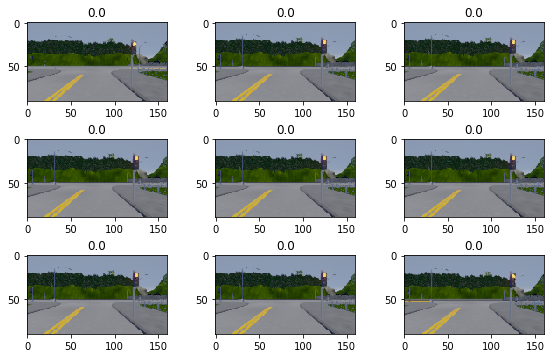

In [9]:
print("image_shape: " + str(X_train[0].shape))
fig = plt.figure(figsize=(8,5))
for i in range(1,10):
    r = np.random.randint(len(images))
    img = images[r]
    img = img
    #img = ((img+0.5))
    #img = img[...,::-1]
    steering = round(float(lines[r][6]), 4)
    fig.add_subplot(3,3,i, title=steering)
    imgplot = plt.imshow(img)
fig.tight_layout()
plt.show()

In [10]:
def hsv_convert(x):
    import tensorflow as tf
    return tf.image.rgb_to_hsv(x)

In [11]:
model = Sequential()
model.add(Lambda(hsv_convert, input_shape=(90,160,3)))
model.add(Conv2D(24,(5,5), strides=(2,2), activation="elu"))
model.add(Conv2D(36,(5,5), strides=(2,2), activation="elu"))
model.add(Conv2D(48,(5,5), strides=(2,2), activation="elu"))
model.add(Conv2D(64,(3,3), activation="elu"))
model.add(Conv2D(64,(3,3), activation="elu"))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation="elu"))
model.add(Dense(50, activation="elu"))
model.add(Dense(10, activation="elu"))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
"""model = Sequential()
model.add(Lambda(hsv_convert, input_shape=(180,320, 3)))
model.add(Conv2D(3,(1,1), activation="elu"))

model.add(Conv2D(32,(3,3), activation="elu"))
model.add(Conv2D(32,(3,3), activation="elu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64,(3,3), activation="elu"))
model.add(Conv2D(64,(3,3), activation="elu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128,(3,3), activation="elu"))
model.add(Conv2D(128,(3,3), activation="elu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(100, activation="elu"))
model.add(Dense(64, activation="elu"))
model.add(Dense(16, activation="elu"))
model.add(Dense(1))
"""

'model = Sequential()\nmodel.add(Lambda(hsv_convert, input_shape=(180,320, 3)))\nmodel.add(Conv2D(3,(1,1), activation="elu"))\n\nmodel.add(Conv2D(32,(3,3), activation="elu"))\nmodel.add(Conv2D(32,(3,3), activation="elu"))\nmodel.add(MaxPooling2D(pool_size=(2,2)))\nmodel.add(Dropout(0.5))\n\nmodel.add(Conv2D(64,(3,3), activation="elu"))\nmodel.add(Conv2D(64,(3,3), activation="elu"))\nmodel.add(MaxPooling2D(pool_size=(2,2)))\nmodel.add(Dropout(0.5))\n\nmodel.add(Conv2D(128,(3,3), activation="elu"))\nmodel.add(Conv2D(128,(3,3), activation="elu"))\nmodel.add(MaxPooling2D(pool_size=(2,2)))\nmodel.add(Dropout(0.5))\n\n\nmodel.add(Flatten())\nmodel.add(Dense(100, activation="elu"))\nmodel.add(Dense(64, activation="elu"))\nmodel.add(Dense(16, activation="elu"))\nmodel.add(Dense(1))\n'

In [13]:
checkpointer = ModelCheckpoint(filepath="./checkpoints/model-{epoch:02d}.hdf5", verbose=1)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [14]:
model.fit(
    X_train, 
    y_train,
    batch_size=8,
    validation_data=(X_valid, y_valid),
    shuffle=True,
    epochs=2,
    verbose=1)#, callbacks=[checkpointer])

#model.save('model.h5')

Instructions for updating:
Use tf.cast instead.
Train on 16 samples, validate on 5 samples
Epoch 1/2
16/16 [==============================] - 2s 97ms/step - loss: 186.6297 - acc: 0.0625 - val_loss: 0.3176 - val_acc: 0.0000e+00
Epoch 2/2
16/16 [==============================] - 0s 788us/step - loss: 0.2536 - acc: 0.6250 - val_loss: 0.3642 - val_acc: 0.0000e+00


In [15]:
print(model.predict(X_valid[4].reshape(1,90,160,3), batch_size=1))
print(y_valid[4])

[[0.61438483]]
0.0
